In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from main import measure
from helper import view, view_phase

# Setup
## Load the sample

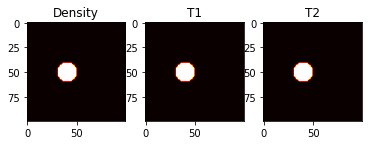

In [2]:
sample = np.load(f"{os.getcwd()}/sample.npy")
view(sample)

## Setup magnetic field
It is necessary to add some noise to the magnetic field. Otherwise, the magnetic
field will be perfectly homogenous, which is unrealistic. Furthermore, is a slight
inhomogeneity in the magnetic field necessary for spin echos.

In [3]:
b0 = np.zeros(sample.shape[:2])
b0.fill(0.43)
b0 += np.random.normal(0, 0.01, b0.shape)

Setup phases and measurement time

Summation of the waiting time between the $90^\circ$ pulses:
$$\sum_{i=1}^n t_{rec} \cdot i = t_{rec} \cdot \sum_{i=1}^n i = t_{rec} \cdot \frac{n^2+n}{2}$$

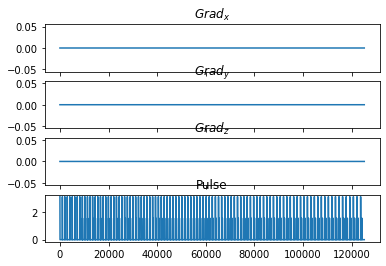

In [4]:
pause_time = 1000  # ms  Time between the different measurements
recovery_time_step = 5  # ms  Time between the 90 degree pulses
points = 100
tfactor = 1  # how many steps per 1ms

t = pause_time * points + recovery_time_step * (points**2 + points) // 2 # ms

# phases = [Gradx, Grady, Gradz, Pulse]
phases = np.zeros((t * tfactor, 4))
time = 0
peaks = []
for i in range(points):
    phases[tfactor * time, 3] = np.pi  # first 180 degree pulse
    time += recovery_time_step * (i + 1)
    phases[tfactor * time, 3] = np.pi / 2  # sec 90 degree pulse
    peaks.append(tfactor * time)
    time += pause_time

view_phase(phases, tfactor)


# Measure

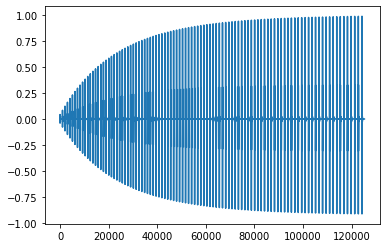

In [5]:
signal = measure(sample, b0, tfactor, phases)
plt.plot(signal)
plt.show()

# Results
Fit exponential function to determine $T_1$.

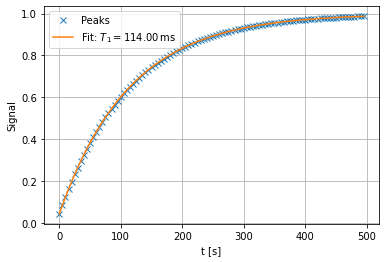

In [6]:
ts = [recovery_time_step * i for i in range(points)]

f = lambda t, t1, a, b: a * (1 - np.exp(- (t + b) / t1))
popt, pcov = curve_fit(f, ts, signal[peaks], p0=[100, 10, 0])
f = np.vectorize(lambda t: popt[1] * (1 - np.exp(- (t + popt[2]) / popt[0])))

plt.plot(ts, signal[peaks], "x", label="Peaks")
plt.plot(ts, f(ts), label=f"Fit: $T_1 = {popt[0]:.2f}\,$ms")
plt.ylabel("Signal")
plt.xlabel("t [s]")
plt.grid()
plt.legend()
plt.show()

This result is consistent with the value we inserted into the measurement.
Since the simulation can not determine material specific properties, these were
encoded into the sample.

In [7]:
print(np.max(sample[:, :, 1]))

114
